In [17]:
import torch
import torchaudio
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp32')
tacotron2 = tacotron2.to('cuda').eval()

Using cache found in /home/vvh413/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [18]:
texts_en = [
    "The results indicate that MelGAN is comparable to some of the best performing models to date as a vocoder component of TTS pipeline.",
]
texts_ru = [
    "Киты - морские млекопитающие из инфраотряда китообразных, не относящиеся ни к дельфинам, ни к морским свиньям.",
    "Косатка и гринды имеют слово кит в своих неофициальных названиях, хотя по строгой таксономии они являются дельфинами.",
    "В устаревшей классификации под китами подразумевали гладких китов. В старину под словом кит иногда подразумевался левиафан."
]

In [19]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

Using cache found in /home/vvh413/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [35]:
from melgan.generator import Generator

MODEL_TAG = "melgan_8192_22k_100_slaney_norm_f"
# MODEL_TAG = "melgan_8192_22k_100_slaney_norm_f"
gen = Generator(80, 32, 3).to("cuda")
gen.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/gen_9.pt", map_location="cuda"))
gen = gen.eval()

In [36]:
from IPython.display import Audio, display
from matplotlib import pyplot as plt

In [37]:
for i, text in enumerate(texts_en):
    sequences, lengths = utils.prepare_input_sequence([text])
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        audio = gen(mel)
    audio_numpy = audio[0].data.cpu().numpy()
    rate = 22050
    
    plt.subplot(len(texts), 1, i + 1)
    plt.imshow(mel.cpu()[0])
    
    display(Audio(audio_numpy, rate=rate))
    
    torchaudio.save(f"test.wav", audio[0].cpu(), rate)

In [10]:
from audio_generation.tacotron_vw.model import Tacotron

tacotron_vw = Tacotron(38).to("cuda").eval()
# tacotron_vw.load_state_dict(torch.load("", map_location="cuda"))

In [12]:
import numpy as np
import re

# VOCAB = np.load("vocab.npy")
def transform_single_text(text):
    text = text.lower()
    text = re.sub('[^А-я \!\?\.\,\-]+', '', text)
    temp_res = []
    for letter in text:
        index = np.where(VOCAB == letter)[0][0]
        temp_res.append(index)
    return temp_res

def code_text(text):
    text = transform_single_text(text)
    text = torch.tensor(text).unsqueeze(0)
    return text

In [14]:
text = "проверка связи"
# text = texts_ru[0]
seq = code_text(text)

NameError: name 'VOCAB' is not defined

In [ ]:
with torch.no_grad():
    mel = torch.nn.functional.relu(tacotron_vw.predict(seq))
    audio = gen(mel)

plt.imshow(mel.cpu()[0])
display(Audio(audio[0].data.cpu().numpy(), rate=24000))
# torchaudio.save(f"test.wav", audio[0].cpu(), rate)

In [17]:
from espnet2.bin.tts_inference import Text2Speech

lang = 'English'
# model_name = 'kan-bayashi/vctk_gst_transformer'
vocoder_tag = "none"
model_name = "kan-bayashi/ljspeech_transformer"
text2speech = Text2Speech.from_pretrained(model_name, device="cuda")

In [18]:
out = text2speech(texts[0])

In [19]:
out["feat_gen"].transpose(0, 1).size()

torch.Size([80, 833])

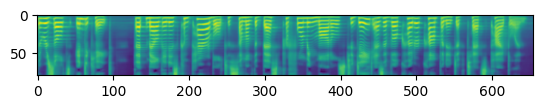

In [21]:
audio = gen(out["feat_gen"].transpose(0, 1))

audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# plt.subplot(audio.size(0), 1, i + 1)
plt.imshow(mel.cpu()[0])
display(Audio(audio_numpy, rate=rate))
torchaudio.save("test.wav", audio.cpu() * 128, rate)

In [21]:
mel.size()

torch.Size([1, 80, 676])

In [47]:
%%time
import torchaudio

invers_transform = torchaudio.transforms.InverseMelScale(
    sample_rate=22050,
    n_stft=513,
    n_mels=80,
    # f_max=8000.0,
    mel_scale="slaney"
).cuda()
grifflim_transform = torchaudio.transforms.GriffinLim(
    n_fft=1024,
    n_iter=100,
    win_length=1024,
    hop_length=256,
    power=1.5
).cuda()

# spec = invers_transform(out["feat_gen"].transpose(0, 1))
spec = invers_transform(torch.exp(mel))
# spec = invers_transform(mel)
print(spec.size())
wav = grifflim_transform(spec)
print(wav.size())
display(Audio(wav.cpu(), rate=22050))

torch.Size([1, 513, 650])
torch.Size([1, 166144])


CPU times: user 11.1 s, sys: 186 ms, total: 11.2 s
Wall time: 11.3 s


In [30]:
torchaudio.save("test.wav", wav.cpu(), rate, encoding="PCM_F")

In [24]:
from TTS.api import TTS

TTS.list_models()

['tts_models/multilingual/multi-dataset/your_tts',
 'tts_models/bg/cv/vits',
 'tts_models/cs/cv/vits',
 'tts_models/da/cv/vits',
 'tts_models/et/cv/vits',
 'tts_models/ga/cv/vits',
 'tts_models/en/ek1/tacotron2',
 'tts_models/en/ljspeech/tacotron2-DDC',
 'tts_models/en/ljspeech/tacotron2-DDC_ph',
 'tts_models/en/ljspeech/glow-tts',
 'tts_models/en/ljspeech/speedy-speech',
 'tts_models/en/ljspeech/tacotron2-DCA',
 'tts_models/en/ljspeech/vits',
 'tts_models/en/ljspeech/vits--neon',
 'tts_models/en/ljspeech/fast_pitch',
 'tts_models/en/ljspeech/overflow',
 'tts_models/en/ljspeech/neural_hmm',
 'tts_models/en/vctk/vits',
 'tts_models/en/vctk/fast_pitch',
 'tts_models/en/sam/tacotron-DDC',
 'tts_models/en/blizzard2013/capacitron-t2-c50',
 'tts_models/en/blizzard2013/capacitron-t2-c150_v2',
 'tts_models/es/mai/tacotron2-DDC',
 'tts_models/es/css10/vits',
 'tts_models/fr/mai/tacotron2-DDC',
 'tts_models/fr/css10/vits',
 'tts_models/uk/mai/glow-tts',
 'tts_models/uk/mai/vits',
 'tts_models/zh

In [25]:
overflow = "tts_models/en/ljspeech/overflow"
speedyspeech = "tts_models/en/ljspeech/speedy-speech"
fast_pitch = "tts_models/en/ljspeech/fast_pitch"

In [26]:
tts = TTS(model_name=fast_pitch, progress_bar=True, gpu=True)

 > tts_models/en/ljspeech/fast_pitch is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: fast_pitch
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Vocoder Model: hifigan
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resam

In [28]:
Audio(tts.tts(texts_en[0]), rate=22050)

 > Text splitted to sentences.
['The results indicate that MelGAN is comparable to some of the best performing models to date as a vocoder component of TTS pipeline.']
 > Processing time: 0.3212409019470215
 > Real-time factor: 0.03998104560604524


In [29]:
tts_model = tts.synthesizer.tts_model

In [30]:
import numpy as np

text_inputs = torch.tensor(np.asarray(
    tts_model.tokenizer.text_to_ids(texts_en[0], language=None),
    dtype=np.int32,
), dtype=torch.long).unsqueeze(0).to("cuda")

In [31]:
text_inputs

tensor([[ 30,  48, 129,  77,  63,  27,  91,  13,  21,  20, 129,  63,  15,   6,
          63,  12,   7,  63,  21, 129,  30,  28,  21, 129,  14,  50,  13,  55,
          48,  15, 129,  63,  27, 129,  12,  48,  14,  17,  28,  77,  48,   4,
          48,  13, 129,  21,  48, 129,  20,  91,  14, 129,  48,  23, 129,  30,
          48, 129,   4,  50,  20,  21, 129,  17,  49,   8,  43,  77,  14,  63,
          33, 129,  14,  40,   6,  48,  13,  27, 129,  21,  48, 129,   6,   7,
          63,  21, 129,  28,  27, 129,  48, 129,  23,  16,  89,  12,  16,  89,
           6,  49, 129,  12,  48,  14,  17,  16,  89,  15,  48,  15,  21, 129,
          48,  23, 129,  21,  20, 129,  17,   3,  63,  17,  13,   3,  63,  15,
         125]], device='cuda:0')

In [32]:
out = tts_model.inference(text_inputs)

In [33]:
out["model_outputs"].transpose(1, 2).size()

torch.Size([1, 80, 643])

In [38]:
audio = gen(out["model_outputs"].transpose(1, 2))

audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# plt.subplot(audio.size(0), 1, i + 1)
plt.imshow(mel.cpu()[0])
display(Audio(audio_numpy, rate=rate))